# LOICA DEMO: SBOL Integration

In [1]:
import sbol3
import sbol2
import tyto
import sbol_utilities
from sbol_utilities import component, conversion
#import seco as seco

#run this at the begining this overwrites the SBOL object because of the name
from flapjack import *
from loica import *

import numpy as np
import getpass
import datetime
import random as rd
import pandas as pd

import matplotlib
%matplotlib inline

In [2]:
user = input()
passwd = getpass.getpass()
fj = Flapjack('flapjack.rudge-lab.org:8000')
fj.log_in(username=user, password=passwd)

# Source

## Flapjack connection

In [3]:
dna = fj.get('dna', name='J23101_GFP')
if len(dna)==0:
    dna = fj.create('dna', name='J23101_GFP')
vector = fj.get('vector', name='J23101_GFP')    
if len(vector)==0:
    vector = fj.create('vector', name='J23101_GFP', dnas=dna.id)   
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')
media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')
    
gfp = fj.get('signal', name='GFP')

biomass_signal = fj.get('signal', name='OD')

def growth_rate(t):
    return gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return gompertz(t, 0.01, 1, 1, 1)

## SBOL Connection

In [4]:
doc = sbol3.Document()
sbol3.set_namespace('https://github.com/Gonza10V')

j23101, j23101_seq = component.promoter('J23101','tttacagctagctcagtcctaggtattatgctagc ', description='https://synbiohub.org/public/igem/BBa_J23101/1')
rbs1, rbs1_seq = component.rbs('RBS1', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAatcacacaggacta', description='BASIC Linker RBS1')

op_j23101 = component.engineered_region('operator_ptet', [j23101,rbs1], description= 'LOICA Operator J23101')

gfpm3, gfpm3_seq = component.cds('GFP_mut3', 'atgcgtaaaggagaagaacttttcactggagttgtcccaattcttgttgaattagatggtgatgttaatgggcacaaattttctgtcagtggagagggtgaaggtgatgcaacatacggaaaacttacccttaaatttatttgcactactggaaaactacctgttccatggccaacacttgtcactactttcggttatggtgttcaatgctttgcgagatacccagatcatatgaaacagcatgactttttcaagagtgccatgcccgaaggttatgtacaggaaagaactatatttttcaaagatgacgggaactacaagacacgtgctgaagtcaagtttgaaggtgatacccttgttaatagaatcgagttaaaaggtattgattttaaagaagatggaaacattcttggacacaaattggaatacaactataactcacacaatgtatacatcatggcagacaaacaaaagaatggaatcaaagttaacttcaaaattagacacaacattgaagatggaagcgttcaactagcagaccattatcaacaaaatactccaattggcgatggccctgtccttttaccagacaaccattacctgtccacacaatctgccctttcgaaagatcccaacgaaaagcgcgaccacatggtccttcttgagtttgtaacagctgctgggattacacatggcatggatgaactatacaaa', description='GFP mut3 Coding Sequence, no BsaI site, no stop codon')
m0050, m0050_seq = component.protein_stability_element('M0050', 'gctgctaacgacgaaaactacgctctggctgctTAAattgaacta', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0050')
ter1, ter1_seq = component.terminator('TER1', 'GTCCatttgtcctactcaggagagcgttcaccgacaaacaacagataaaacgaaaggcccagtctttcgactgagcctttcgttttatttgTAAGGCTCG', description='rrnB T1 terminator from Potvin-Trottier pLPT119, extra stop codon')

gp_gfp = geneproduct = component.engineered_region(f'geneproduct_{gfpm3.name}_{m0050.name}_{ter1.name}', [gfpm3, m0050, ter1], description='LOICA GeneProduct GFP')

doc.add([j23101, j23101_seq, rbs1, rbs1_seq, op_j23101, gfpm3, gfpm3_seq, m0050, m0050_seq, ter1, ter1_seq, gp_gfp])

for obj in doc.objects:
    print(obj.identity)
report_sbol3 = doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/J23101
https://github.com/Gonza10V/J23101_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/GFP_mut3
https://github.com/Gonza10V/GFP_mut3_seq
https://github.com/Gonza10V/M0050
https://github.com/Gonza10V/M0050_seq
https://github.com/Gonza10V/TER1
https://github.com/Gonza10V/TER1_seq
https://github.com/Gonza10V/geneproduct_GFP_mut3_M0050_TER1
0


## GeneticNetwork Construction

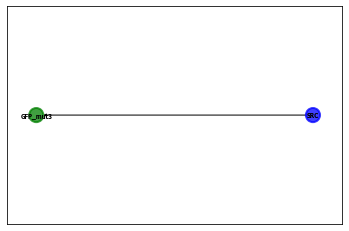

In [5]:
src = GeneticNetwork(vector=vector.id[0])

gfp_rep = Reporter(name='GFP_mut3', degradation_rate=1, signal_id=gfp.id[0], sbol_comp=gp_gfp, color='green')
src.add_reporter(gfp_rep)

j23101_source_gfp = Source(output=gfp_rep, rate=10, sbol_comp=op_j23101)
src.add_operator(j23101_source_gfp)
src.draw()

In [6]:
source_doc = src.to_sbol(sbol_doc=doc)
for obj in source_doc.objects:
    print(obj.identity)
report_sbol3 = source_doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/J23101
https://github.com/Gonza10V/J23101_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/GFP_mut3
https://github.com/Gonza10V/GFP_mut3_seq
https://github.com/Gonza10V/M0050
https://github.com/Gonza10V/M0050_seq
https://github.com/Gonza10V/TER1
https://github.com/Gonza10V/TER1_seq
https://github.com/Gonza10V/geneproduct_GFP_mut3_M0050_TER1
https://github.com/Gonza10V/LOICA_c_SRC_GFP_mut3_model
https://github.com/Gonza10V/TU_SRC_GFP_mut3
https://github.com/Gonza10V/GFP_mut3_protein
https://github.com/Gonza10V/geneticnetwork
0


# Buffer

## Flapjack Connection

In [7]:
dna = fj.get('dna', name='_BUF_GFP')
if len(dna)==0:
    dna = fj.create('dna', name='AHL1_NOT_GFP')
vector = fj.get('vector', name='AHL1_NOT_GFP')    
if len(vector)==0:
    vector = fj.create('vector', name='AHL1_NOT_GFP', dnas=dna.id)   
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')
media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')
    
gfp = fj.get('signal', name='GFP')

biomass_signal = fj.get('signal', name='OD')

def growth_rate(t):
    return gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return gompertz(t, 0.01, 1, 1, 1)

## SBOL Connection

In [8]:
doc = sbol3.Document()
sbol3.set_namespace('https://github.com/Gonza10V')

hsl_c4 = component.ed_simple_chemical('https://pubchem.ncbi.nlm.nih.gov/substance/329748866')
prhl, prhl_seq = component.promoter('pRhl','cagtcgggGGTCTCaGGAGtcctgtgaaatctggcagttaccgttagctttcgaattggctaaaaagtgttcTACTaGAGACCcacgtagtg ', description='https://synbiohub.org/public/igem/BBa_J23101/1')
rbs1, rbs1_seq = component.rbs('RBS1', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAatcacacaggacta', description='BASIC Linker RBS1')
op_prhl = component.engineered_region('operator_ptet', [prhl,rbs1], description= 'LOICA Operator pRhl')

gfpm3, gfpm3_seq = component.cds('GFP_mut3', 'atgcgtaaaggagaagaacttttcactggagttgtcccaattcttgttgaattagatggtgatgttaatgggcacaaattttctgtcagtggagagggtgaaggtgatgcaacatacggaaaacttacccttaaatttatttgcactactggaaaactacctgttccatggccaacacttgtcactactttcggttatggtgttcaatgctttgcgagatacccagatcatatgaaacagcatgactttttcaagagtgccatgcccgaaggttatgtacaggaaagaactatatttttcaaagatgacgggaactacaagacacgtgctgaagtcaagtttgaaggtgatacccttgttaatagaatcgagttaaaaggtattgattttaaagaagatggaaacattcttggacacaaattggaatacaactataactcacacaatgtatacatcatggcagacaaacaaaagaatggaatcaaagttaacttcaaaattagacacaacattgaagatggaagcgttcaactagcagaccattatcaacaaaatactccaattggcgatggccctgtccttttaccagacaaccattacctgtccacacaatctgccctttcgaaagatcccaacgaaaagcgcgaccacatggtccttcttgagtttgtaacagctgctgggattacacatggcatggatgaactatacaaa', description='GFP mut3 Coding Sequence, no BsaI site, no stop codon')
m0050, m0050_seq = component.protein_stability_element('M0050', 'gctgctaacgacgaaaactacgctctggctgctTAAattgaacta', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0050')
ter1, ter1_seq = component.terminator('TER1', 'GTCCatttgtcctactcaggagagcgttcaccgacaaacaacagataaaacgaaaggcccagtctttcgactgagcctttcgttttatttgTAAGGCTCG', description='rrnB T1 terminator from Potvin-Trottier pLPT119, extra stop codon')
gp_gfp = geneproduct = component.engineered_region(f'geneproduct_{gfpm3.name}_{m0050.name}_{ter1.name}', [gfpm3, m0050, ter1], description='LOICA GeneProduct GFP')

doc.add([prhl, prhl_seq, rbs1, rbs1_seq, op_prhl, gfpm3, gfpm3_seq, m0050, m0050_seq, ter1, ter1_seq, gp_gfp])

for obj in doc.objects:
    print(obj.identity)
report_sbol3 = doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/pRhl
https://github.com/Gonza10V/pRhl_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/GFP_mut3
https://github.com/Gonza10V/GFP_mut3_seq
https://github.com/Gonza10V/M0050
https://github.com/Gonza10V/M0050_seq
https://github.com/Gonza10V/TER1
https://github.com/Gonza10V/TER1_seq
https://github.com/Gonza10V/geneproduct_GFP_mut3_M0050_TER1
0


## GeneticNetwork Construction

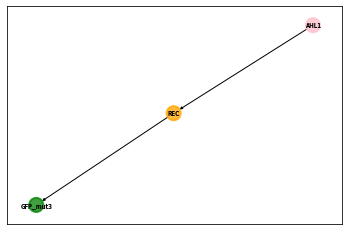

In [9]:
rec = GeneticNetwork(vector=vector.id[0])

gfp_rep = Reporter(name='GFP_mut3', degradation_rate=1, signal_id=gfp.id[0], sbol_comp=gp_gfp, color='green')
rec.add_reporter(gfp_rep)

ahl1 = Supplement(name='AHL1', sbol_comp=hsl_c4)

ahl1_REC_gfp = Receiver(input=ahl1, output=gfp_rep, a=100, b=0, K=1, n=2, sbol_comp=op_prhl)
rec.add_operator(ahl1_REC_gfp)
rec.draw()

In [10]:
rec_doc = rec.to_sbol(sbol_doc=doc)
for obj in rec_doc.objects:
    print(obj.identity)
report_sbol3 = rec_doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/pRhl
https://github.com/Gonza10V/pRhl_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/GFP_mut3
https://github.com/Gonza10V/GFP_mut3_seq
https://github.com/Gonza10V/M0050
https://github.com/Gonza10V/M0050_seq
https://github.com/Gonza10V/TER1
https://github.com/Gonza10V/TER1_seq
https://github.com/Gonza10V/geneproduct_GFP_mut3_M0050_TER1
https://github.com/Gonza10V/LOICA__AHL1_REC_GFP_mut3_model
https://github.com/Gonza10V/TU_AHL1_REC_GFP_mut3
https://github.com/Gonza10V/GFP_mut3_protein
https://github.com/Gonza10V/AHL1_chemical
https://github.com/Gonza10V/geneticnetwork
0


# NOT

## Flapjack Connection

In [3]:
dna = fj.get('dna', name='LacI_NOT_GFP')
if len(dna)==0:
    dna = fj.create('dna', name='LacI_NOT_GFP')
vector = fj.get('vector', name='LacI_NOT_GFP')    
if len(vector)==0:
    vector = fj.create('vector', name='LacI_NOT_GFP', dnas=dna.id)   
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')
media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')
    
gfp = fj.get('signal', name='GFP')

biomass_signal = fj.get('signal', name='OD')

def growth_rate(t):
    return gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return gompertz(t, 0.01, 1, 1, 1)

## SBOL Connection

In [4]:
doc = sbol3.Document()
sbol3.set_namespace('https://github.com/Gonza10V')

plac, plac_seq = component.promoter('L3S2P11_UPA20_pLac_RiboJ10', 'GTCCCTCGGTACCAAATTCCAGAAAAGAGACGCTTTCGAGCGTCTTTTTTCGTTTTGGTCCGTGCCTACTCTGGAAAATCTcctttcgtcttcacctcgagaattgtgagcggataacaattgacattgtgagcggataacaagatactgagcacatcagcaggacgcactgaccgaattcattAGCGCTCAACGGGTGTGCTTCCCGTTCTGATGAGTCCGTGAGGACGAAAGCGCCTCTACAAATAATTTTGTTTAAGGCTCG', description='BASIC - Potvin pLac (based on B-P39-pLac-F2)')
rbs1, rbs1_seq = component.rbs('RBS1', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAatcacacaggacta', description='BASIC Linker RBS1')
op_plac = component.engineered_region('operator_ptet', [plac,rbs1], description= 'LOICA Operator pLac')

gfpm3, gfpm3_seq = component.cds('GFP_mut3', 'atgcgtaaaggagaagaacttttcactggagttgtcccaattcttgttgaattagatggtgatgttaatgggcacaaattttctgtcagtggagagggtgaaggtgatgcaacatacggaaaacttacccttaaatttatttgcactactggaaaactacctgttccatggccaacacttgtcactactttcggttatggtgttcaatgctttgcgagatacccagatcatatgaaacagcatgactttttcaagagtgccatgcccgaaggttatgtacaggaaagaactatatttttcaaagatgacgggaactacaagacacgtgctgaagtcaagtttgaaggtgatacccttgttaatagaatcgagttaaaaggtattgattttaaagaagatggaaacattcttggacacaaattggaatacaactataactcacacaatgtatacatcatggcagacaaacaaaagaatggaatcaaagttaacttcaaaattagacacaacattgaagatggaagcgttcaactagcagaccattatcaacaaaatactccaattggcgatggccctgtccttttaccagacaaccattacctgtccacacaatctgccctttcgaaagatcccaacgaaaagcgcgaccacatggtccttcttgagtttgtaacagctgctgggattacacatggcatggatgaactatacaaa', description='GFP mut3 Coding Sequence, no BsaI site, no stop codon')
m0050, m0050_seq = component.protein_stability_element('M0050', 'gctgctaacgacgaaaactacgctctggctgctTAAattgaacta', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0050')
ter1, ter1_seq = component.terminator('TER1', 'GTCCatttgtcctactcaggagagcgttcaccgacaaacaacagataaaacgaaaggcccagtctttcgactgagcctttcgttttatttgTAAGGCTCG', description='rrnB T1 terminator from Potvin-Trottier pLPT119, extra stop codon')
gp_gfp = geneproduct = component.engineered_region(f'geneproduct_{gfpm3.name}_{m0050.name}_{ter1.name}', [gfpm3, m0050, ter1], description='LOICA GeneProduct GFP')

laci, laci_seq = component.cds('LacI', 'GTCCatggtgaatgtgaaaccagtaacgttatacgatgtcgcagagtatgccggtgtctcttatcagaccgtttcccgcgtggtgaaccaggccagccacgtttctgcgaaaacgcgggaaaaagtggaagcggcgatggcggagctgaattacattcccaaccgcgtggcacaacaactggcgggcaaacagtcgttgctgattggcgttgccacctccagtctggccctgcacgcgccgtcgcaaattgtcgcggcgattaaatctcgcgccgatcaactgggtgccagcgtggtggtgtcgatggtagaacgaagcggcgtcgaagcctgtaaagcggcggtgcacaatcttctcgcgcaacgcgtcagtgggctgatcattaactatccgctggatgaccaggatgccattgctgtggaagctgcctgcactaatgttccggcgttatttcttgatgtctctgaccagacacccatcaacagtattattttctcccatgaagacggtacgcgactgggcgtggagcatctggtcgcattgggtcaccagcaaatcgcgctgttagcgggcccattaagttctgtctcggcgcgtctgcgtctggctggctggcataaatatctcactcgcaatcaaattcagccgatagcggaacgggaaggcgactggagtgccatgtccggttttcaacaaaccatgcaaatgctgaatgagggcatcgttcccactgcgatgctggttgccaacgatcagatggcgctgggcgcaatgcgcgccattaccgagtccgggctgcgcgttggtgcggatatctcggtagtgggatacgacgataccgaagacagctcatgttatatcccgccgttaaccaccatcaaacaggattttcgcctgctggggcaaaccagcgtggaccgcttgctgcaactctctcagggccaggcggtgaagggcaatcagctgttgcccgtctcactggtgaaaagaaaaaccaccctggcgcccaatacgcaaaccgcctctccccgcgcgttggccgattcattaatgcagctggcacgacaggtttcccgactggaaagcgggcagGGCTCG', description='LacI Coding Sequence from Potvin-Trottier pLPT119, no stop codon')
gp_laci = geneproduct = component.engineered_region(f'geneproduct_{laci.name}_{m0050.name}_{ter1.name}', [laci, m0050, ter1], description='LOICA GeneProduct LacI')

doc.add([plac, plac_seq, rbs1, rbs1_seq, op_plac, gfpm3, gfpm3_seq, m0050, m0050_seq, ter1, ter1_seq, gp_gfp, laci, laci_seq, gp_laci])

for obj in doc.objects:
    print(obj.identity)
report_sbol3 = doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/L3S2P11_UPA20_pLac_RiboJ10
https://github.com/Gonza10V/L3S2P11_UPA20_pLac_RiboJ10_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/GFP_mut3
https://github.com/Gonza10V/GFP_mut3_seq
https://github.com/Gonza10V/M0050
https://github.com/Gonza10V/M0050_seq
https://github.com/Gonza10V/TER1
https://github.com/Gonza10V/TER1_seq
https://github.com/Gonza10V/geneproduct_GFP_mut3_M0050_TER1
https://github.com/Gonza10V/LacI
https://github.com/Gonza10V/LacI_seq
https://github.com/Gonza10V/geneproduct_LacI_M0050_TER1
0


## GeneticNetwork Construction

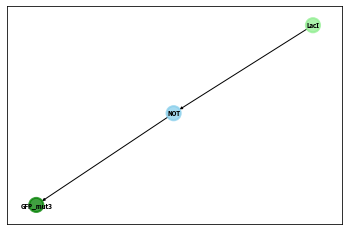

In [5]:
inv = GeneticNetwork(vector=vector.id[0])

gfp_rep = Reporter(name='GFP_mut3', degradation_rate=1, signal_id=gfp.id[0], sbol_comp=gp_gfp, color='green')
inv.add_reporter(gfp_rep)

laci_reg = Regulator(name='LacI', degradation_rate=1, init_concentration=5, sbol_comp=gp_laci)
inv.add_regulator(laci_reg)

laci_NOT_gfp = Not(input=laci_reg, output=gfp_rep, a=100, b=0, K=1, n=2, sbol_comp=op_plac)
inv.add_operator(laci_NOT_gfp)
inv.draw()

In [6]:
inv_doc = inv.to_sbol(sbol_doc=doc)
for obj in inv_doc.objects:
    print(obj.identity)
report_sbol3 = inv_doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/L3S2P11_UPA20_pLac_RiboJ10
https://github.com/Gonza10V/L3S2P11_UPA20_pLac_RiboJ10_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/GFP_mut3
https://github.com/Gonza10V/GFP_mut3_seq
https://github.com/Gonza10V/M0050
https://github.com/Gonza10V/M0050_seq
https://github.com/Gonza10V/TER1
https://github.com/Gonza10V/TER1_seq
https://github.com/Gonza10V/geneproduct_GFP_mut3_M0050_TER1
https://github.com/Gonza10V/LacI
https://github.com/Gonza10V/LacI_seq
https://github.com/Gonza10V/geneproduct_LacI_M0050_TER1
https://github.com/Gonza10V/LOICA__LacI_NOT_GFP_mut3_model
https://github.com/Gonza10V/TU_LacI_NOT_GFP_mut3
https://github.com/Gonza10V/LacI_protein
https://github.com/Gonza10V/GFP_mut3_protein
https://github.com/Gonza10V/geneticnetwork
0


In [7]:
for error in report_sbol3.errors:
    print(error.object_id)
    print(error.message)

# Receiver

## Flapjack Connection

In [ ]:
dna = fj.get('dna', name='AHL1_REC_GFP')
if len(dna)==0:
    dna = fj.create('dna', name='AHL1_REC_GFP')
vector = fj.get('vector', name='AHL1_REC_GFP')    
if len(vector)==0:
    vector = fj.create('vector', name='AHL1_REC_GFP', dnas=dna.id)   
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')
media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')
    
gfp = fj.get('signal', name='GFP')

biomass_signal = fj.get('signal', name='OD')

def growth_rate(t):
    return gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return gompertz(t, 0.01, 1, 1, 1)

## SBOL Connection

In [ ]:
doc = sbol3.Document()
sbol3.set_namespace('https://github.com/Gonza10V')

hsl_c4 = component.ed_simple_chemical('https://pubchem.ncbi.nlm.nih.gov/substance/329748866')
prhl, prhl_seq = component.promoter('pRhl','cagtcgggGGTCTCaGGAGtcctgtgaaatctggcagttaccgttagctttcgaattggctaaaaagtgttcTACTaGAGACCcacgtagtg ', description='https://synbiohub.org/public/igem/BBa_J23101/1')
rbs1, rbs1_seq = component.rbs('RBS1', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAatcacacaggacta', description='BASIC Linker RBS1')
op_prhl = component.engineered_region('operator_ptet', [prhl,rbs1], description= 'LOICA Operator pRhl')

gfpm3, gfpm3_seq = component.cds('GFP_mut3', 'atgcgtaaaggagaagaacttttcactggagttgtcccaattcttgttgaattagatggtgatgttaatgggcacaaattttctgtcagtggagagggtgaaggtgatgcaacatacggaaaacttacccttaaatttatttgcactactggaaaactacctgttccatggccaacacttgtcactactttcggttatggtgttcaatgctttgcgagatacccagatcatatgaaacagcatgactttttcaagagtgccatgcccgaaggttatgtacaggaaagaactatatttttcaaagatgacgggaactacaagacacgtgctgaagtcaagtttgaaggtgatacccttgttaatagaatcgagttaaaaggtattgattttaaagaagatggaaacattcttggacacaaattggaatacaactataactcacacaatgtatacatcatggcagacaaacaaaagaatggaatcaaagttaacttcaaaattagacacaacattgaagatggaagcgttcaactagcagaccattatcaacaaaatactccaattggcgatggccctgtccttttaccagacaaccattacctgtccacacaatctgccctttcgaaagatcccaacgaaaagcgcgaccacatggtccttcttgagtttgtaacagctgctgggattacacatggcatggatgaactatacaaa', description='GFP mut3 Coding Sequence, no BsaI site, no stop codon')
m0050, m0050_seq = component.protein_stability_element('M0050', 'gctgctaacgacgaaaactacgctctggctgctTAAattgaacta', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0050')
ter1, ter1_seq = component.terminator('TER1', 'GTCCatttgtcctactcaggagagcgttcaccgacaaacaacagataaaacgaaaggcccagtctttcgactgagcctttcgttttatttgTAAGGCTCG', description='rrnB T1 terminator from Potvin-Trottier pLPT119, extra stop codon')
gp_gfp = geneproduct = component.engineered_region(f'geneproduct_{gfpm3.name}_{m0050.name}_{ter1.name}', [gfpm3, m0050, ter1], description='LOICA GeneProduct GFP')

doc.add([prhl, prhl_seq, rbs1, rbs1_seq, op_prhl, gfpm3, gfpm3_seq, m0050, m0050_seq, ter1, ter1_seq, gp_gfp])

for obj in doc.objects:
    print(obj.identity)
report_sbol3 = doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/pRhl
https://github.com/Gonza10V/pRhl_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/GFP_mut3
https://github.com/Gonza10V/GFP_mut3_seq
https://github.com/Gonza10V/M0050
https://github.com/Gonza10V/M0050_seq
https://github.com/Gonza10V/TER1
https://github.com/Gonza10V/TER1_seq
https://github.com/Gonza10V/geneproduct_GFP_mut3_M0050_TER1
0


## GeneticNetwork Construction

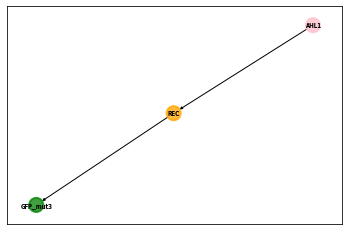

In [ ]:
rec = GeneticNetwork(vector=vector.id[0])

gfp_rep = Reporter(name='GFP_mut3', degradation_rate=1, signal_id=gfp.id[0], sbol_comp=gp_gfp, color='green')
rec.add_reporter(gfp_rep)

ahl1 = Supplement(name='AHL1', sbol_comp=hsl_c4)

ahl1_REC_gfp = Receiver(input=ahl1, output=gfp_rep, a=100, b=0, K=1, n=2, sbol_comp=op_prhl)
rec.add_operator(ahl1_REC_gfp)
rec.draw()

In [ ]:
rec_doc = rec.to_sbol(sbol_doc=doc)
for obj in rec_doc.objects:
    print(obj.identity)
report_sbol3 = rec_doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/pRhl
https://github.com/Gonza10V/pRhl_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/GFP_mut3
https://github.com/Gonza10V/GFP_mut3_seq
https://github.com/Gonza10V/M0050
https://github.com/Gonza10V/M0050_seq
https://github.com/Gonza10V/TER1
https://github.com/Gonza10V/TER1_seq
https://github.com/Gonza10V/geneproduct_GFP_mut3_M0050_TER1
https://github.com/Gonza10V/LOICA__AHL1_REC_GFP_mut3_model
https://github.com/Gonza10V/TU_AHL1_REC_GFP_mut3
https://github.com/Gonza10V/AHL1_chemical
https://github.com/Gonza10V/GFP_mut3_protein
https://github.com/Gonza10V/geneticnetwork
0


# NOR

## Flapjack Connection

In [12]:
dna_rec1 = fj.get('dna', name='AHL1_REC_LacI')
if len(dna)==0:
    dna_rec1 = fj.create('dna', name='AHL1_REC_TetR')

dna_rec2 = fj.get('dna', name='AHL2_REC_LacI')
if len(dna_OR)==0:
    dna_rec2 = fj.create('dna', name='AHL2_REC_LacI')

dna_NOR = fj.get('dna', name='LacI_TetR_NOR_GFP')
if len(dna_NOT)==0:
    dna_NOR = fj.create('dna', name='LacI_TetR_NOR_GFP')

vector = fj.get('vector', name='AHL1_AHL2_NOR_GFP')    
if len(vector)==0:
    vector = fj.create('vector', name='AHL1_AHL2_NOR_GFP', dnas=[dna_rec1.id, dna_rec2.id, dna_NOR.id])   

study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')

media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')

strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')
    
gfp = fj.get('signal', name='GFP')

biomass_signal = fj.get('signal', name='OD')

def growth_rate(t):
    return gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return gompertz(t, 0.01, 1, 1, 1)

## SBOL Connection

In [13]:
doc = sbol3.Document()
sbol3.set_namespace('https://github.com/Gonza10V')

tdm_pro, tdm_pro_seq = component.promoter('TP_laci_tetr','cagtcgggGGTCTCaGGAGtcctgtgaaatctggcagttaccgttagctttcgaattggctaaaaagtgttccctttccgaaacgaaacaagttggattttgccagtcgggGGTCTCaGGAGtcctgtgaaatctggcagttaccgttagctttcgaattggctaaaaagtgttccctttccgaaacgaaacaagttggattttgc acctaccagaactggtagttctgacctgtggctatcttcgaaggcatcgatattatgcacattggaactcttcatgacataacgccgagTACTaGAGACCcacgtagtg ', description='https://synbiohub.org/public/igem/BBa_J23101/1')
rbs1, rbs1_seq = component.rbs('RBS1', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAatcacacaggacta', description='BASIC Linker RBS1')

op_tdm_pro = component.engineered_region('operator_ptet', [tdm_pro,rbs1], description= 'LOICA Operator J23101')

gfpm3, gfpm3_seq = component.cds('GFP_mut3', 'atgcgtaaaggagaagaacttttcactggagttgtcccaattcttgttgaattagatggtgatgttaatgggcacaaattttctgtcagtggagagggtgaaggtgatgcaacatacggaaaacttacccttaaatttatttgcactactggaaaactacctgttccatggccaacacttgtcactactttcggttatggtgttcaatgctttgcgagatacccagatcatatgaaacagcatgactttttcaagagtgccatgcccgaaggttatgtacaggaaagaactatatttttcaaagatgacgggaactacaagacacgtgctgaagtcaagtttgaaggtgatacccttgttaatagaatcgagttaaaaggtattgattttaaagaagatggaaacattcttggacacaaattggaatacaactataactcacacaatgtatacatcatggcagacaaacaaaagaatggaatcaaagttaacttcaaaattagacacaacattgaagatggaagcgttcaactagcagaccattatcaacaaaatactccaattggcgatggccctgtccttttaccagacaaccattacctgtccacacaatctgccctttcgaaagatcccaacgaaaagcgcgaccacatggtccttcttgagtttgtaacagctgctgggattacacatggcatggatgaactatacaaa', description='GFP mut3 Coding Sequence, no BsaI site, no stop codon')
m0050, m0050_seq = component.protein_stability_element('M0050', 'gctgctaacgacgaaaactacgctctggctgctTAAattgaacta', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0050')
ter1, ter1_seq = component.terminator('TER1', 'GTCCatttgtcctactcaggagagcgttcaccgacaaacaacagataaaacgaaaggcccagtctttcgactgagcctttcgttttatttgTAAGGCTCG', description='rrnB T1 terminator from Potvin-Trottier pLPT119, extra stop codon')

gp_gfp = geneproduct = component.engineered_region(f'geneproduct_{gfpm3.name}_{m0050.name}_{ter1.name}', [gfpm3, m0050, ter1], description='LOICA GeneProduct GFP')

hsl_c4 = component.ed_simple_chemical('https://pubchem.ncbi.nlm.nih.gov/substance/329748866')
hsl_c6 = component.ed_simple_chemical('https://pubchem.ncbi.nlm.nih.gov/substance/329748862')
doc.add([tdm_pro, tdm_pro_seq, rbs1, rbs1_seq, op_tdm_pro, gfpm3, gfpm3_seq, m0050, m0050_seq, ter1, ter1_seq, gp_gfp])

for obj in doc.objects:
    print(obj.identity)
report_sbol3 = doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/TP_rhl_Las
https://github.com/Gonza10V/TP_rhl_Las_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/GFP_mut3
https://github.com/Gonza10V/GFP_mut3_seq
https://github.com/Gonza10V/M0050
https://github.com/Gonza10V/M0050_seq
https://github.com/Gonza10V/TER1
https://github.com/Gonza10V/TER1_seq
https://github.com/Gonza10V/geneproduct_GFP_mut3_M0050_TER1
0


## GeneticNetwork Construction

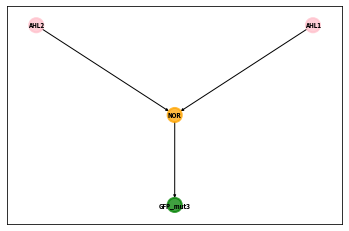

In [14]:
nor_ex = GeneticNetwork(vector=vector.id[0])

gfp_rep = Reporter(name='GFP_mut3', degradation_rate=1, signal_id=gfp.id[0], sbol_comp=gp_gfp, color='green')
nor_ex.add_reporter(gfp_rep)

ahl1 = Supplement(name='AHL1', sbol_comp=hsl_c4)
ahl2 = Supplement(name='AHL2', sbol_comp=hsl_c6)

nor_ex.add_operator(Nor(input=[ahl1, ahl2], output=gfp_rep, 
                    alpha=[0.0001,1,1,0], K=[1,1], n=[2,2], sbol_comp=op_tdm_pro))
nor_ex.draw()

In [15]:
nor_doc = nor_ex.to_sbol(sbol_doc=doc)
for obj in nor_doc.objects:
    print(obj.identity)
report_sbol3 = nor_doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/TP_rhl_Las
https://github.com/Gonza10V/TP_rhl_Las_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/GFP_mut3
https://github.com/Gonza10V/GFP_mut3_seq
https://github.com/Gonza10V/M0050
https://github.com/Gonza10V/M0050_seq
https://github.com/Gonza10V/TER1
https://github.com/Gonza10V/TER1_seq
https://github.com/Gonza10V/geneproduct_GFP_mut3_M0050_TER1
https://github.com/Gonza10V/LOICA__AHL1_AHL2_NOR_GFP_mut3_model
https://github.com/Gonza10V/TU_NOR_GFP_mut3
https://github.com/Gonza10V/GFP_mut3_protein
https://github.com/Gonza10V/AHL2_chemical
https://github.com/Gonza10V/AHL1_chemical
https://github.com/Gonza10V/geneticnetwork
0


# Reppresilator

## Flapjack Connection

In [3]:
dna = fj.get('dna', name='Rep')
if len(dna)==0:
    dna = fj.create('dna', name='Rep')
vector = fj.get('vector', name='Rep')    
if len(vector)==0:
    vector = fj.create('vector', name='Rep', dnas=dna.id)   
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')
media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')
    
cfp = fj.get('signal', name='CFP')
yfp = fj.get('signal', name='YFP')
rfp = fj.get('signal', name='RFP')

biomass_signal = fj.get('signal', name='OD')

def growth_rate(t):
    return gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return gompertz(t, 0.01, 1, 1, 1)

## SBOL Connection

In [35]:
doc = sbol3.Document()
sbol3.set_namespace('https://github.com/Gonza10V')

ptet, ptet_seq = component.promoter('L3S2P21_UPA20_pTetR_RiboJ','GTCCCTCGGTACCAAATTCCAGAAAAGAGGCCTCCCGAAAGGGGGGCCTTTTTTCGTTTTGGTCCGTGCCTACTCTGGAAAATCTtccctatcagtgatagagattgacatccctatcagtgatagagatactgagcacatcagcaggacgcactgaccAGCTGTCACCGGATGTGCTTTCCGGTCTGATGAGTCCGTGAGGACGAAACAGCCTCTACAAATAATTTTGTTTAAGGCTCG', description='BASIC - Potvin pTet (based on B-P27-pTetR-F1)')
plac, plac_seq = component.promoter('L3S2P11_UPA20_pLac_RiboJ10', 'GTCCCTCGGTACCAAATTCCAGAAAAGAGACGCTTTCGAGCGTCTTTTTTCGTTTTGGTCCGTGCCTACTCTGGAAAATCTcctttcgtcttcacctcgagaattgtgagcggataacaattgacattgtgagcggataacaagatactgagcacatcagcaggacgcactgaccgaattcattAGCGCTCAACGGGTGTGCTTCCCGTTCTGATGAGTCCGTGAGGACGAAAGCGCCTCTACAAATAATTTTGTTTAAGGCTCG', description='BASIC - Potvin pLac (based on B-P39-pLac-F2)')
plam, plam_seq = component.promoter('L3S1P13_UPA20_plambda_RiboJ51', 'GTCCGACGAACAATAAGGCCTCCCTAACGGGGGGCCTTTTTTATTGATAACAAAAGTGCCTACTCTGGAAAATCTccgccgccctagacctagctgcaggtcgaggataaatatctaacaccgtgcgtgttgactattttacctctggcggtgataatggttgcatgtactagaattcattAGTAGTCACCGGCTGTGCTTGCCGGTCTGATGAGCCTGTGAAGGCGAAACTACCTCTACAAATAATTTTGTTTAAGGCTCG', description='BASIC - Potvin plambda (based on B-P41-pPhlF-F3)')

op_ptet = component.engineered_region('operator_ptet', [ptet], description= 'LOICA Operator pTet')
op_plac = component.engineered_region('operator_plac', [plac], description='LOICA Operator pLac')
op_plam = component.engineered_region('operator_plam', [plam], description='LOICA Operator pLambda')

toplevels = [ptet, ptet_seq, plac, plac_seq, plam, plam_seq, op_ptet, op_plac, op_plam]
doc.add(toplevels)

operators = [op_ptet, op_plac, op_plam]

for obj in doc.objects:
    print(obj.identity)
report_sbol3 = doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/L3S2P21_UPA20_pTetR_RiboJ
https://github.com/Gonza10V/L3S2P21_UPA20_pTetR_RiboJ_seq
https://github.com/Gonza10V/L3S2P11_UPA20_pLac_RiboJ10
https://github.com/Gonza10V/L3S2P11_UPA20_pLac_RiboJ10_seq
https://github.com/Gonza10V/L3S1P13_UPA20_plambda_RiboJ51
https://github.com/Gonza10V/L3S1P13_UPA20_plambda_RiboJ51_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/operator_plac
https://github.com/Gonza10V/operator_plam
0


In [36]:
rbs1, rbs1_seq = component.rbs('RBS1', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAatcacacaggacta', description='BASIC Linker RBS1')
rbs2, rbs2_seq = component.rbs('RBS2', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAaaagaggggaaata', description='BASIC Linker RBS2')
rbs3, rbs3_seq = component.rbs('RBS3', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAaaagaggagaaata', description='BASIC Linker RBS3')

mven, mven_seq = component.cds('mVenus', 'GTCCCTCGGTACCAAATTCCAGAAAAGAGGCCTCCCGAAAGGGGGGCCTTTTTTCGTTTTGGTCCGTGCCTACTCTGGAAAATCTtccctatcagtgatagagattgacatccctatcagtgatagagatactgagcacatcagcaggacgcactgaccAGCTGTCACCGGATGTGCTTTCCGGTCTGATGAGTCCGTGAGGACGAAACAGCCTCTACAAATAATTTTGTTTAAGGCTCG', description='mVenus Coding Sequence from Potvin-Trottier pLPT119, no BasI site, no stop codon')
tetr, tetr_seq = component.cds('TetR', 'GTCCatgtccagattagataaaagtaaagtgattaacagcgcattagagctgcttaatgaggtcggaatcgaaggtttaacaacccgtaaactcgcccagaagctaggtgtagagcagcctacattgtattggcatgtaaaaaataagcgggctttgctcgacgccttagccattgagatgttagataggcaccatactcacttttgccctttagaaggggaaagctggcaagattttttacgtaataacgctaaaagttttagatgtgctttactaagtcatcgcgatggagcaaaagtacatttaggtacacggcctacagaaaaacagtatgaaactctcgaaaatcaattagcctttttatgccaacaaggtttttcactagagaatgcattatatgcactcagcgctgtggggcattttactttaggttgcgtattggaagatcaagagcatcaagtcgctaaagaagaaagggaaacacctactactgatagtatgccgccattattacgacaagctatcgaattatttgatcaccaaggtgcagagccagccttcttattcggccttgaattgatcatatgcggattagaaaaacaacttaaatgtgaaagtgggtctGGCTCG',description='TetR Coding Sequence from Potvin-Trottier pLPT119, no stop codon')
laci, laci_seq = component.cds('LacI', 'GTCCatggtgaatgtgaaaccagtaacgttatacgatgtcgcagagtatgccggtgtctcttatcagaccgtttcccgcgtggtgaaccaggccagccacgtttctgcgaaaacgcgggaaaaagtggaagcggcgatggcggagctgaattacattcccaaccgcgtggcacaacaactggcgggcaaacagtcgttgctgattggcgttgccacctccagtctggccctgcacgcgccgtcgcaaattgtcgcggcgattaaatctcgcgccgatcaactgggtgccagcgtggtggtgtcgatggtagaacgaagcggcgtcgaagcctgtaaagcggcggtgcacaatcttctcgcgcaacgcgtcagtgggctgatcattaactatccgctggatgaccaggatgccattgctgtggaagctgcctgcactaatgttccggcgttatttcttgatgtctctgaccagacacccatcaacagtattattttctcccatgaagacggtacgcgactgggcgtggagcatctggtcgcattgggtcaccagcaaatcgcgctgttagcgggcccattaagttctgtctcggcgcgtctgcgtctggctggctggcataaatatctcactcgcaatcaaattcagccgatagcggaacgggaaggcgactggagtgccatgtccggttttcaacaaaccatgcaaatgctgaatgagggcatcgttcccactgcgatgctggttgccaacgatcagatggcgctgggcgcaatgcgcgccattaccgagtccgggctgcgcgttggtgcggatatctcggtagtgggatacgacgataccgaagacagctcatgttatatcccgccgttaaccaccatcaaacaggattttcgcctgctggggcaaaccagcgtggaccgcttgctgcaactctctcagggccaggcggtgaagggcaatcagctgttgcccgtctcactggtgaaaagaaaaaccaccctggcgcccaatacgcaaaccgcctctccccgcgcgttggccgattcattaatgcagctggcacgacaggtttcccgactggaaagcgggcagGGCTCG', description='LacI Coding Sequence from Potvin-Trottier pLPT119, no stop codon')
lamr, lamr_seq = component.cds('LamR', 'GTCCCTCGGTACCAAATTCCAGAAAAGAGGCCTCCCGAAAGGGGGGCCTTTTTTCGTTTTGGTCCGTGCCTACTCTGGAAAATCTtccctatcagtgatagagattgacatccctatcagtgatagagatactgagcacatcagcaggacgcactgaccAGCTGTCACCGGATGTGCTTTCCGGTCTGATGAGTCCGTGAGGACGAAACAGCCTCTACAAATAATTTTGTTTAAGGCTCG', description='lambdaR Coding Sequence from Potvin-Trottier pLPT119, no stop codon')

m0050, m0050_seq = component.protein_stability_element('M0050', 'gctgctaacgacgaaaactacgctctggctgctTAAattgaacta', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0050')
m0051, m0051_seq = component.protein_stability_element('M0051', 'gctgctaacgacgaaaactacaactacgctgacgcttctTAActa', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0051')
m0052, m0052_seq = component.protein_stability_element('M0052', 'gctgctaacgacgaaaactacgctgacgcttctTAAattgaacta', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0052')

ter1, ter1_seq = component.terminator('TER1', 'GTCCatttgtcctactcaggagagcgttcaccgacaaacaacagataaaacgaaaggcccagtctttcgactgagcctttcgttttatttgTAAGGCTCG', description='rrnB T1 terminator from Potvin-Trottier pLPT119, extra stop codon')

toplevels = [rbs1, rbs1_seq, rbs2, rbs2_seq, rbs3, rbs3_seq, mven, mven_seq, tetr, tetr_seq, 
            laci, laci_seq, lamr, lamr_seq, m0050, m0050_seq, m0051, m0051_seq, m0052, m0052_seq, ter1, ter1_seq]
doc.add(toplevels)

# Automate design from lists of components, could be a collection
rbss = [rbs1] # [rbs1, rbs2, rbs3]
cdss = [mven, tetr, laci, lamr]
degtags = [m0050] # [m0050, m0051, m0052]
terminators = [ter1]

# Wrap it together
geneproducts = []
for rbs in rbss:
    for cds in cdss:
        for degtag in degtags:
            for ter in terminators:
                geneproduct = component.engineered_region(f'geneproduct_{rbs.name}_{cds.name}_{degtag.name}_{ter.name}', [rbs, cds, degtag, ter], description='LOICA gene product')
                doc.add(geneproduct)
                geneproducts.append(geneproduct)

for obj in doc.objects:
    print(obj.identity)
report_sbol3 = doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/L3S2P21_UPA20_pTetR_RiboJ
https://github.com/Gonza10V/L3S2P21_UPA20_pTetR_RiboJ_seq
https://github.com/Gonza10V/L3S2P11_UPA20_pLac_RiboJ10
https://github.com/Gonza10V/L3S2P11_UPA20_pLac_RiboJ10_seq
https://github.com/Gonza10V/L3S1P13_UPA20_plambda_RiboJ51
https://github.com/Gonza10V/L3S1P13_UPA20_plambda_RiboJ51_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/operator_plac
https://github.com/Gonza10V/operator_plam
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/RBS2
https://github.com/Gonza10V/RBS2_seq
https://github.com/Gonza10V/RBS3
https://github.com/Gonza10V/RBS3_seq
https://github.com/Gonza10V/mVenus
https://github.com/Gonza10V/mVenus_seq
https://github.com/Gonza10V/TetR
https://github.com/Gonza10V/TetR_seq
https://github.com/Gonza10V/LacI
https://github.com/Gonza10V/LacI_seq
https://github.com/Gonza10V/LamR
https://github.com/Gonza10V/LamR_seq
https://github.com/Gonza10V/M0050


## GeneticNetwork Construction

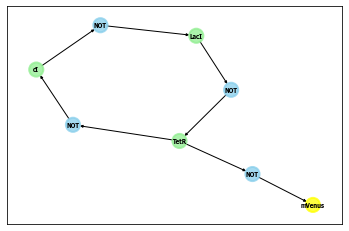

In [24]:
rep = GeneticNetwork(vector=vector.id[0])

tetr_reg = Regulator(name='TetR', degradation_rate=1, sbol_comp=geneproducts[1])
laci_reg = Regulator(name='LacI', degradation_rate=1, init_concentration=5, sbol_comp=geneproducts[2])
ci_reg = Regulator(name='cI', degradation_rate=1, sbol_comp=geneproducts[3])
rep.add_regulators([tetr_reg, laci_reg, ci_reg])

mven_rep = Reporter(name='mVenus', degradation_rate=1, signal_id=yfp.id[0], sbol_comp=geneproducts[0], color='yellow')
rep.add_reporter(mven_rep)

laci_not_tetr = Not(input=laci_reg, output=tetr_reg, a=100, b=0, K=1, n=2, sbol_comp=op_plac)
ci_not_laci = Not(input=ci_reg, output=laci_reg, a=100, b=0, K=1, n=2, sbol_comp=op_plam)
tetr_not_ci = Not(input=tetr_reg, output=ci_reg, a=100, b=0, K=1, n=2, sbol_comp=op_ptet)
tetr_not_mven = Not(input=tetr_reg, output=mven_rep, a=100, b=0, K=1, n=2, sbol_comp=op_ptet)
rep.add_operators([laci_not_tetr, ci_not_laci, tetr_not_ci, tetr_not_mven])
rep.draw()

In [25]:
repressilator_doc = rep.to_sbol(sbol_doc=doc)
for obj in repressilator_doc.objects:
    print(obj.identity)
report_sbol3 = repressilator_doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/L3S2P21_UPA20_pTetR_RiboJ
https://github.com/Gonza10V/L3S2P21_UPA20_pTetR_RiboJ_seq
https://github.com/Gonza10V/L3S2P11_UPA20_pLac_RiboJ10
https://github.com/Gonza10V/L3S2P11_UPA20_pLac_RiboJ10_seq
https://github.com/Gonza10V/L3S1P13_UPA20_plambda_RiboJ51
https://github.com/Gonza10V/L3S1P13_UPA20_plambda_RiboJ51_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/operator_plac
https://github.com/Gonza10V/operator_plam
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/RBS2
https://github.com/Gonza10V/RBS2_seq
https://github.com/Gonza10V/RBS3
https://github.com/Gonza10V/RBS3_seq
https://github.com/Gonza10V/mVenus
https://github.com/Gonza10V/mVenus_seq
https://github.com/Gonza10V/TetR
https://github.com/Gonza10V/TetR_seq
https://github.com/Gonza10V/LacI
https://github.com/Gonza10V/LacI_seq
https://github.com/Gonza10V/LamR
https://github.com/Gonza10V/LamR_seq
https://github.com/Gonza10V/M0050


## Save and Load

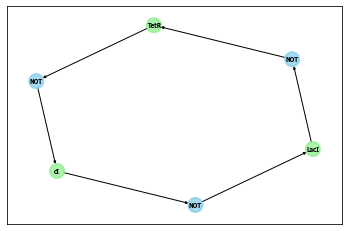

In [37]:
rep = GeneticNetwork(vector=vector.id[0])

tetr_reg = Regulator(name='TetR', degradation_rate=1, sbol_comp=geneproducts[1])
laci_reg = Regulator(name='LacI', degradation_rate=1, init_concentration=5, sbol_comp=geneproducts[2])
ci_reg = Regulator(name='cI', degradation_rate=1, sbol_comp=geneproducts[3])
rep.add_regulators([tetr_reg, laci_reg, ci_reg])

#mven_rep = Reporter(name='mVenus', degradation_rate=1, signal_id=yfp.id[0], sbol_comp=geneproducts[0], color='yellow')
#rep.add_reporter(mven_rep)

laci_not_tetr = Not(input=laci_reg, output=tetr_reg, a=100, b=0, K=1, n=2, sbol_comp=op_plac)
ci_not_laci = Not(input=ci_reg, output=laci_reg, a=100, b=0, K=1, n=2, sbol_comp=op_plam)
tetr_not_ci = Not(input=tetr_reg, output=ci_reg, a=100, b=0, K=1, n=2, sbol_comp=op_ptet)
#tetr_not_mven = Not(input=tetr_reg, output=mven_rep, a=100, b=0, K=1, n=2, sbol_comp=op_ptet)
rep.add_operators([laci_not_tetr, ci_not_laci, tetr_not_ci]) #tetr_not_mven])
rep.draw()

In [38]:
save_loica(rep, 'repressilator_mvenus')

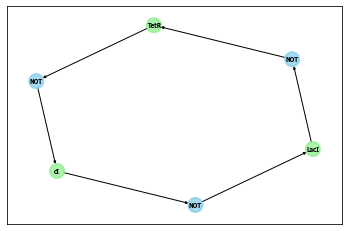

In [39]:
loaded_rep = load_loica('repressilator_mvenus')
loaded_rep.draw()

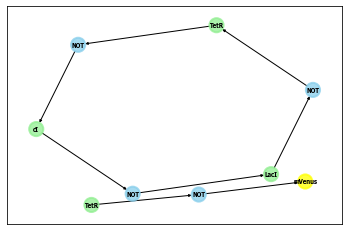

In [40]:
loaded_rep = load_loica('repressilator_mvenus')
mven_rep = Reporter(name='mVenus', degradation_rate=1, signal_id=yfp.id[0], sbol_comp=geneproducts[0], color='yellow')
loaded_rep.add_reporter(mven_rep)
tetr_not_mven = Not(input=tetr_reg, output=mven_rep, a=100, b=0, K=1, n=2, sbol_comp=op_ptet)
loaded_rep.add_operators([tetr_not_mven])
loaded_rep.draw()

### How to connect a new network to a loaded network

Loaded networks and newly created networks are not connected with the same objects. The loaded objects needs to be connected to the new parts providing a link from the loaded network to the new parts of the network.

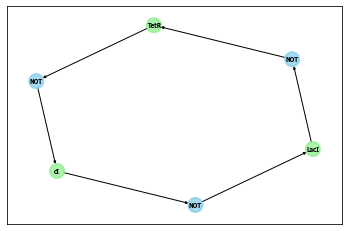

In [41]:
loaded_rep = load_loica('repressilator_mvenus')
loaded_rep.draw()

In [42]:
for r in rep.regulators:
    print(r.name)

TetR
LacI
cI


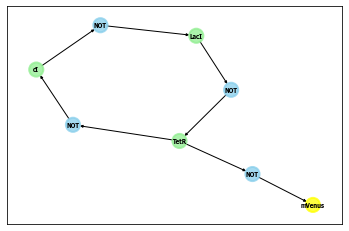

In [43]:
mven_rep = Reporter(name='mVenus', degradation_rate=1, signal_id=yfp.id[0], sbol_comp=geneproducts[0], color='yellow')
loaded_rep.add_reporter(mven_rep)
tetr_not_mven = Not(input=loaded_rep.regulators[0], output=mven_rep, a=100, b=0, K=1, n=2, sbol_comp=op_ptet)
loaded_rep.add_operators([tetr_not_mven])
loaded_rep.draw()

To have a valid SBOL Dcoument please run again the SBOL Connection cells. This is to avoid having duplicated parts on the document from the first repressilator.

In [44]:
repressilator_doc = loaded_rep.to_sbol(sbol_doc=doc)
for obj in repressilator_doc.objects:
    print(obj.identity)
report_sbol3 = repressilator_doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/L3S2P21_UPA20_pTetR_RiboJ
https://github.com/Gonza10V/L3S2P21_UPA20_pTetR_RiboJ_seq
https://github.com/Gonza10V/L3S2P11_UPA20_pLac_RiboJ10
https://github.com/Gonza10V/L3S2P11_UPA20_pLac_RiboJ10_seq
https://github.com/Gonza10V/L3S1P13_UPA20_plambda_RiboJ51
https://github.com/Gonza10V/L3S1P13_UPA20_plambda_RiboJ51_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/operator_plac
https://github.com/Gonza10V/operator_plam
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/RBS2
https://github.com/Gonza10V/RBS2_seq
https://github.com/Gonza10V/RBS3
https://github.com/Gonza10V/RBS3_seq
https://github.com/Gonza10V/mVenus
https://github.com/Gonza10V/mVenus_seq
https://github.com/Gonza10V/TetR
https://github.com/Gonza10V/TetR_seq
https://github.com/Gonza10V/LacI
https://github.com/Gonza10V/LacI_seq
https://github.com/Gonza10V/LamR
https://github.com/Gonza10V/LamR_seq
https://github.com/Gonza10V/M0050


In [8]:
for error in report_sbol3.errors:
    print(error.object_id)
    print(error.message)

# Composed  GeneticNetwork

# Receiver C4

## Flapjack Connection

In [ ]:
dna = fj.get('dna', name='AHL1_REC_GFP')
if len(dna)==0:
    dna = fj.create('dna', name='AHL1_REC_GFP')
vector = fj.get('vector', name='AHL1_REC_GFP')    
if len(vector)==0:
    vector = fj.create('vector', name='AHL1_REC_GFP', dnas=dna.id)   
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')
media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')
    
gfp = fj.get('signal', name='GFP')

biomass_signal = fj.get('signal', name='OD')

def growth_rate(t):
    return gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return gompertz(t, 0.01, 1, 1, 1)

## SBOL Connection

In [47]:
doc = sbol3.Document()
sbol3.set_namespace('https://github.com/Gonza10V')

hsl_c4 = component.ed_simple_chemical('https://pubchem.ncbi.nlm.nih.gov/substance/329748866')
prhl, prhl_seq = component.promoter('pRhl','cagtcgggGGTCTCaGGAGtcctgtgaaatctggcagttaccgttagctttcgaattggctaaaaagtgttcTACTaGAGACCcacgtagtg ', description='https://synbiohub.org/public/igem/BBa_J23101/1')
rbs1, rbs1_seq = component.rbs('RBS1', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAatcacacaggacta', description='BASIC Linker RBS1')
op_prhl = component.engineered_region('operator_ptet', [prhl,rbs1], description= 'LOICA Operator pRhl')

laci, laci_seq = component.cds('LacI', 'GTCCatggtgaatgtgaaaccagtaacgttatacgatgtcgcagagtatgccggtgtctcttatcagaccgtttcccgcgtggtgaaccaggccagccacgtttctgcgaaaacgcgggaaaaagtggaagcggcgatggcggagctgaattacattcccaaccgcgtggcacaacaactggcgggcaaacagtcgttgctgattggcgttgccacctccagtctggccctgcacgcgccgtcgcaaattgtcgcggcgattaaatctcgcgccgatcaactgggtgccagcgtggtggtgtcgatggtagaacgaagcggcgtcgaagcctgtaaagcggcggtgcacaatcttctcgcgcaacgcgtcagtgggctgatcattaactatccgctggatgaccaggatgccattgctgtggaagctgcctgcactaatgttccggcgttatttcttgatgtctctgaccagacacccatcaacagtattattttctcccatgaagacggtacgcgactgggcgtggagcatctggtcgcattgggtcaccagcaaatcgcgctgttagcgggcccattaagttctgtctcggcgcgtctgcgtctggctggctggcataaatatctcactcgcaatcaaattcagccgatagcggaacgggaaggcgactggagtgccatgtccggttttcaacaaaccatgcaaatgctgaatgagggcatcgttcccactgcgatgctggttgccaacgatcagatggcgctgggcgcaatgcgcgccattaccgagtccgggctgcgcgttggtgcggatatctcggtagtgggatacgacgataccgaagacagctcatgttatatcccgccgttaaccaccatcaaacaggattttcgcctgctggggcaaaccagcgtggaccgcttgctgcaactctctcagggccaggcggtgaagggcaatcagctgttgcccgtctcactggtgaaaagaaaaaccaccctggcgcccaatacgcaaaccgcctctccccgcgcgttggccgattcattaatgcagctggcacgacaggtttcccgactggaaagcgggcagGGCTCG', description='LacI Coding Sequence from Potvin-Trottier pLPT119, no stop codon')
m0050, m0050_seq = component.protein_stability_element('M0050', 'gctgctaacgacgaaaactacgctctggctgctTAAattgaacta', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0050')
ter1, ter1_seq = component.terminator('TER1', 'GTCCatttgtcctactcaggagagcgttcaccgacaaacaacagataaaacgaaaggcccagtctttcgactgagcctttcgttttatttgTAAGGCTCG', description='rrnB T1 terminator from Potvin-Trottier pLPT119, extra stop codon')
gp_laci = geneproduct = component.engineered_region(f'geneproduct_{laci.name}_{m0050.name}_{ter1.name}', [laci, m0050, ter1], description='LOICA GeneProduct LacI')

doc.add([prhl, prhl_seq, rbs1, rbs1_seq, op_prhl, laci, laci_seq, m0050, m0050_seq, ter1, ter1_seq, gp_laci])

for obj in doc.objects:
    print(obj.identity)
report_sbol3 = doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/pRhl
https://github.com/Gonza10V/pRhl_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/LacI
https://github.com/Gonza10V/LacI_seq
https://github.com/Gonza10V/M0050
https://github.com/Gonza10V/M0050_seq
https://github.com/Gonza10V/TER1
https://github.com/Gonza10V/TER1_seq
https://github.com/Gonza10V/geneproduct_LacI_M0050_TER1
0


## GeneticNetwork Construction

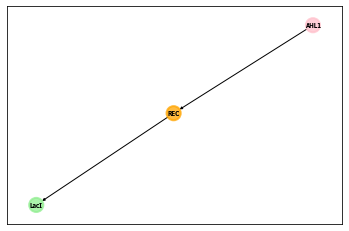

In [52]:
rec1 = GeneticNetwork(vector=vector.id[0])

laci_reg = Regulator(name='LacI', degradation_rate=1, sbol_comp=gp_laci )
rec1.add_regulator(laci_reg)

ahl1 = Supplement(name='AHL1', sbol_comp=hsl_c4)

ahl1_REC_laci = Receiver(input=ahl1, output=laci_reg, a=100, b=0, K=1, n=2, sbol_comp=op_prhl)
rec1.add_operator(ahl1_REC_laci)
rec1.draw()

In [53]:
rec_doc = rec1.to_sbol(sbol_doc=doc)
for obj in rec_doc.objects:
    print(obj.identity)
report_sbol3 = rec_doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/pRhl
https://github.com/Gonza10V/pRhl_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/LacI
https://github.com/Gonza10V/LacI_seq
https://github.com/Gonza10V/M0050
https://github.com/Gonza10V/M0050_seq
https://github.com/Gonza10V/TER1
https://github.com/Gonza10V/TER1_seq
https://github.com/Gonza10V/geneproduct_LacI_M0050_TER1
https://github.com/Gonza10V/LOICA__AHL1_REC_LacI_model
https://github.com/Gonza10V/TU_AHL1_REC_LacI
https://github.com/Gonza10V/AHL1_chemical
https://github.com/Gonza10V/LacI_protein
https://github.com/Gonza10V/geneticnetwork
0


In [54]:
save_loica(rec1, 'hsl1_REC_laci')

# Receiver C6

## Flapjack Connection

In [65]:
dna = fj.get('dna', name='AHL2_REC_TetR')
if len(dna)==0:
    dna = fj.create('dna', name='AHL2_REC_TetR')
vector = fj.get('vector', name='AHL2_REC_TetR')    
if len(vector)==0:
    vector = fj.create('vector', name='AHL2_REC_TetR', dnas=dna.id)   
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')
media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')
    
gfp = fj.get('signal', name='GFP')

biomass_signal = fj.get('signal', name='OD')

def growth_rate(t):
    return gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return gompertz(t, 0.01, 1, 1, 1)

## SBOL Connection

In [69]:
doc = sbol3.Document()
sbol3.set_namespace('https://github.com/Gonza10V')

hsl_c6 = component.ed_simple_chemical('https://pubchem.ncbi.nlm.nih.gov/substance/329758205')
plux, plux_seq = component.promoter('pRhl','cagtcgggGGTCTCaGGAGtcctgtgaaatctggcagttaccgttagctttcgaattggctaaaaagtgttcTACTaGAGACCcacgtagtg ', description='https://synbiohub.org/public/igem/BBa_J23101/1')
rbs1, rbs1_seq = component.rbs('RBS1', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAatcacacaggacta', description='BASIC Linker RBS1')
op_plux = component.engineered_region('operator_ptet', [plux,rbs1], description= 'LOICA Operator pRhl')

tetr, tetr_seq = component.cds('TetR', 'GTCCatgtccagattagataaaagtaaagtgattaacagcgcattagagctgcttaatgaggtcggaatcgaaggtttaacaacccgtaaactcgcccagaagctaggtgtagagcagcctacattgtattggcatgtaaaaaataagcgggctttgctcgacgccttagccattgagatgttagataggcaccatactcacttttgccctttagaaggggaaagctggcaagattttttacgtaataacgctaaaagttttagatgtgctttactaagtcatcgcgatggagcaaaagtacatttaggtacacggcctacagaaaaacagtatgaaactctcgaaaatcaattagcctttttatgccaacaaggtttttcactagagaatgcattatatgcactcagcgctgtggggcattttactttaggttgcgtattggaagatcaagagcatcaagtcgctaaagaagaaagggaaacacctactactgatagtatgccgccattattacgacaagctatcgaattatttgatcaccaaggtgcagagccagccttcttattcggccttgaattgatcatatgcggattagaaaaacaacttaaatgtgaaagtgggtctGGCTCG',description='TetR Coding Sequence from Potvin-Trottier pLPT119, no stop codon')
m0050, m0050_seq = component.protein_stability_element('M0050', 'gctgctaacgacgaaaactacgctctggctgctTAAattgaacta', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0050')
ter1, ter1_seq = component.terminator('TER1', 'GTCCatttgtcctactcaggagagcgttcaccgacaaacaacagataaaacgaaaggcccagtctttcgactgagcctttcgttttatttgTAAGGCTCG', description='rrnB T1 terminator from Potvin-Trottier pLPT119, extra stop codon')
gp_tetr = geneproduct = component.engineered_region(f'geneproduct_{tetr.name}_{m0050.name}_{ter1.name}', [tetr, m0050, ter1], description='LOICA GeneProduct TetR')

doc.add([plux, plux_seq, rbs1, rbs1_seq, op_plux, tetr, tetr_seq, m0050, m0050_seq, ter1, ter1_seq, gp_tetr])

for obj in doc.objects:
    print(obj.identity)
report_sbol3 = doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/pRhl
https://github.com/Gonza10V/pRhl_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/TetR
https://github.com/Gonza10V/TetR_seq
https://github.com/Gonza10V/M0050
https://github.com/Gonza10V/M0050_seq
https://github.com/Gonza10V/TER1
https://github.com/Gonza10V/TER1_seq
https://github.com/Gonza10V/geneproduct_TetR_M0050_TER1
0


## GeneticNetwork Construction

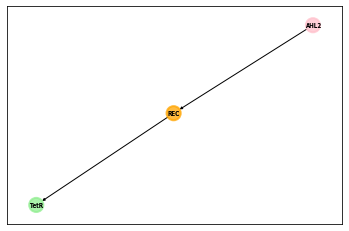

In [70]:
rec2 = GeneticNetwork(vector=vector.id[0])

tetr_reg = Regulator(name='TetR', degradation_rate=1, sbol_comp=gp_tetr)
rec2.add_regulator(tetr_reg)

ahl2 = Supplement(name='AHL2', sbol_comp=hsl_c6)

ahl2_REC_tetr = Receiver(input=ahl2, output=tetr_reg, a=100, b=0, K=1, n=2, sbol_comp=op_plux)
rec2.add_operator(ahl2_REC_tetr)
rec2.draw()

In [71]:
rec_doc = rec2.to_sbol(sbol_doc=doc)
for obj in rec_doc.objects:
    print(obj.identity)
report_sbol3 = rec_doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/pRhl
https://github.com/Gonza10V/pRhl_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/TetR
https://github.com/Gonza10V/TetR_seq
https://github.com/Gonza10V/M0050
https://github.com/Gonza10V/M0050_seq
https://github.com/Gonza10V/TER1
https://github.com/Gonza10V/TER1_seq
https://github.com/Gonza10V/geneproduct_TetR_M0050_TER1
https://github.com/Gonza10V/LOICA__AHL2_REC_TetR_model
https://github.com/Gonza10V/TU_AHL2_REC_TetR
https://github.com/Gonza10V/AHL2_chemical
https://github.com/Gonza10V/TetR_protein
https://github.com/Gonza10V/geneticnetwork
0


In [72]:
save_loica(rec2, 'hsl2_REC_tetr')

# LacI_TetR_NOR_GFP

## Flapjack Connection

In [83]:
dna_rec1 = fj.create('dna', name='AHL1_REC_TetR')

dna_rec2 = fj.create('dna', name='AHL2_REC_LacI')

dna_NOR = fj.create('dna', name='LacI_TetR_NOR_GFP')

vector = fj.create('vector', name='AHL1_AHL2_NOR_GFP', dnas=[dna_rec1.id, dna_rec2.id, dna_NOR.id])   

study = fj.create('study', name='Loica testing', description='Test')

media = fj.create('media', name='Loica', description='Simulated loica media')

strain = fj.create('strain', name='Loica strain', description='Loica test strain')
    
gfp = fj.get('signal', name='GFP')

biomass_signal = fj.get('signal', name='OD')

def growth_rate(t):
    return gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return gompertz(t, 0.01, 1, 1, 1)

## SBOL Connection

In [105]:
doc = sbol3.Document()
sbol3.set_namespace('https://github.com/Gonza10V')

tdm_pro, tdm_pro_seq = component.promoter('TP_laci_tetr','cagtcgggGGTCTCaGGAGtcctgtgaaatctggcagttaccgttagctttcgaattggctaaaaagtgttccctttccgaaacgaaacaagttggattttgccagtcgggGGTCTCaGGAGtcctgtgaaatctggcagttaccgttagctttcgaattggctaaaaagtgttccctttccgaaacgaaacaagttggattttgc acctaccagaactggtagttctgacctgtggctatcttcgaaggcatcgatattatgcacattggaactcttcatgacataacgccgagTACTaGAGACCcacgtagtg ', description='https://synbiohub.org/public/igem/BBa_J23101/1')
rbs1, rbs1_seq = component.rbs('RBS1', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAatcacacaggacta', description='BASIC Linker RBS1')

op_tdm_pro = component.engineered_region('operator_ptet', [tdm_pro,rbs1], description= 'LOICA Operator J23101')

gfpm3, gfpm3_seq = component.cds('GFP_mut3', 'atgcgtaaaggagaagaacttttcactggagttgtcccaattcttgttgaattagatggtgatgttaatgggcacaaattttctgtcagtggagagggtgaaggtgatgcaacatacggaaaacttacccttaaatttatttgcactactggaaaactacctgttccatggccaacacttgtcactactttcggttatggtgttcaatgctttgcgagatacccagatcatatgaaacagcatgactttttcaagagtgccatgcccgaaggttatgtacaggaaagaactatatttttcaaagatgacgggaactacaagacacgtgctgaagtcaagtttgaaggtgatacccttgttaatagaatcgagttaaaaggtattgattttaaagaagatggaaacattcttggacacaaattggaatacaactataactcacacaatgtatacatcatggcagacaaacaaaagaatggaatcaaagttaacttcaaaattagacacaacattgaagatggaagcgttcaactagcagaccattatcaacaaaatactccaattggcgatggccctgtccttttaccagacaaccattacctgtccacacaatctgccctttcgaaagatcccaacgaaaagcgcgaccacatggtccttcttgagtttgtaacagctgctgggattacacatggcatggatgaactatacaaa', description='GFP mut3 Coding Sequence, no BsaI site, no stop codon')
m0050, m0050_seq = component.protein_stability_element('M0050', 'gctgctaacgacgaaaactacgctctggctgctTAAattgaacta', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0050')
ter1, ter1_seq = component.terminator('TER1', 'GTCCatttgtcctactcaggagagcgttcaccgacaaacaacagataaaacgaaaggcccagtctttcgactgagcctttcgttttatttgTAAGGCTCG', description='rrnB T1 terminator from Potvin-Trottier pLPT119, extra stop codon')

gp_gfp = geneproduct = component.engineered_region(f'geneproduct_{gfpm3.name}_{m0050.name}_{ter1.name}', [gfpm3, m0050, ter1], description='LOICA GeneProduct GFP')

hsl_c4 = component.ed_simple_chemical('https://pubchem.ncbi.nlm.nih.gov/substance/329748866')
hsl_c6 = component.ed_simple_chemical('https://pubchem.ncbi.nlm.nih.gov/substance/329748862')
doc.add([tdm_pro, tdm_pro_seq, rbs1, rbs1_seq, op_tdm_pro, gfpm3, gfpm3_seq, m0050, m0050_seq, ter1, ter1_seq, gp_gfp])

for obj in doc.objects:
    print(obj.identity)
report_sbol3 = doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/TP_laci_tetr
https://github.com/Gonza10V/TP_laci_tetr_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/GFP_mut3
https://github.com/Gonza10V/GFP_mut3_seq
https://github.com/Gonza10V/M0050
https://github.com/Gonza10V/M0050_seq
https://github.com/Gonza10V/TER1
https://github.com/Gonza10V/TER1_seq
https://github.com/Gonza10V/geneproduct_GFP_mut3_M0050_TER1
0


## GeneticNetwork Construction

In [106]:
hsl1_REC_laci = load_loica('hsl1_REC_laci')

In [107]:
hsl1_REC_laci.regulators[0].name

'LacI'

In [108]:
hsl2_REC_tetr = load_loica('hsl2_REC_tetr')

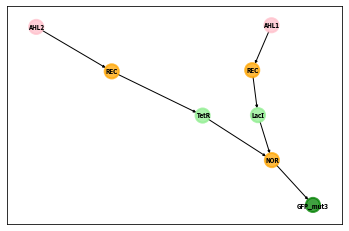

In [111]:
nor_ex = GeneticNetwork(vector=vector.id[0])

gfp_rep = Reporter(name='GFP_mut3', degradation_rate=1, signal_id=gfp.id[0], sbol_comp=gp_gfp, color='green')
nor_ex.add_reporter(gfp_rep)

nor_ex.add_operators([hsl1_REC_laci.operators[0], hsl2_REC_tetr.operators[0]])

laci = hsl1_REC_laci.regulators[0]
tetr = hsl2_REC_tetr.regulators[0]

nor_ex.add_operator(Nor(input=[laci, tetr], output=gfp_rep, 
                    alpha=[0.0001,1,1,0], K=[1,1], n=[2,2], sbol_comp=op_tdm_pro))
nor_ex.draw()

In [ ]:
nor_doc = nor_ex.to_sbol(sbol_doc=doc)
for obj in nor_doc.objects:
    print(obj.identity)
report_sbol3 = nor_doc.validate()
print(len(report_sbol3))